<a href="https://colab.research.google.com/github/PietrOz/pietroz_learning/blob/master/GAN_ime_MilanMeetup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting the GPU as Runtime Machine

In [1]:
!nvidia-smi

Sat Mar 14 09:24:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install torchviz

     |████████████████████████████████| 51kB 3.1MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=68536e68988dceaabbb6b5532598e833cd796bd6ad4de2da21f11cbd6b70ff2a
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [0]:
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch as t
import matplotlib.pyplot as plt
import numpy as np
seed = 999
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import itertools

import glob,os,random
from PIL import Image

import datetime
import time
import sys

random.seed(seed)
from torchviz import make_dot


In [4]:
use_cuda = t.cuda.is_available()
device = t.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [7]:
cd drive/My\ Drive/

[Errno 2] No such file or directory: 'drive/My Drive/'
/content


In [6]:
import zipfile
with zipfile.ZipFile("selfie2anime_AB.zip", 'r') as zip_ref:
    zip_ref.extractall("selfie2anime_AB")

FileNotFoundError: ignored

In [0]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = t.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(t.cat(to_return))


In [0]:
#variables and parameters
epoch = 0
n_epochs = 200
batch_size = 1
lr = 0.0002
b1 = 0.5
b2 = 0.999
decay_epoch=100
n_cpu = 8

img_height = 256
img_width = 256
channels = 3

sample_interval = 100
checkpoint_interval = -1
n_residual_blocks = 9
lambda_cyc = 10.0
lambda_id = 5.0

input_shape = (channels, img_height, img_width)
dataset_folder ="selfie2anime_AB/selfie2anime_AB/"
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()


In [0]:
class ImageDataset(Dataset):
    
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, "%s/A" % mode) + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, "%s/B" % mode) + "/*.*"))

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = self.to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = self.to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        
        return {"A": item_A, "B": item_B}
    
    def to_rgb(self,image):
        rgb_image = Image.new("RGB", image.size)
        rgb_image.paste(image)
        return rgb_image

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [0]:
# Image transformations
transforms_ = [
    transforms.Resize(int(img_height * 1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

# Training data loader
dataloader = DataLoader(
    ImageDataset(root=dataset_folder, transforms_=transforms_, unaligned=True),
    batch_size=batch_size,
    shuffle=True
)
# Test data loader
val_dataloader = DataLoader(
    ImageDataset(root=dataset_folder, transforms_=transforms_, unaligned=True, mode="test"),
    batch_size=5,
    shuffle=True,
)


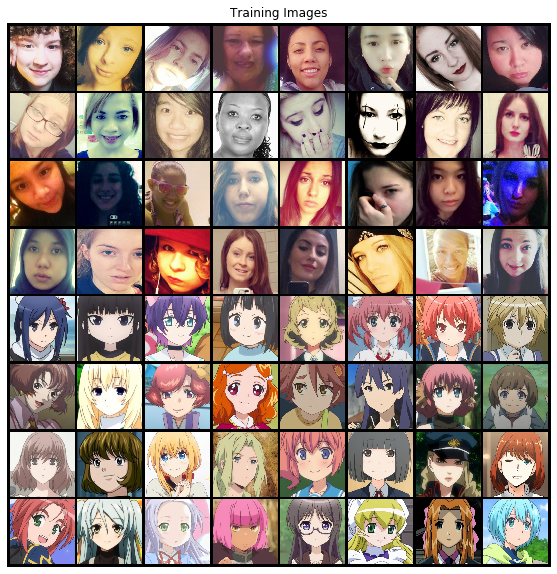

In [0]:
sample_A,sample_B = t.Tensor(),t.Tensor()

for i in range(32):
    data = iter(dataloader).next()
    A,B = data["A"],data["B"]
    sample_A = t.cat((sample_A,A),dim=0)
    sample_B = t.cat((sample_B,B),dim=0)

sample_test_images = t.cat((sample_A,sample_B),dim=0)
sample_test_images.to(device)

grid = vutils.make_grid(sample_test_images, padding=10, normalize=True,pad_value=0).cpu()
grid = np.transpose(grid,(1,2,0))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")

plt.imshow(grid)
plt.show()

In [0]:
class ResidualBlock(t.nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = t.nn.Sequential(
            t.nn.ReflectionPad2d(1),
            t.nn.Conv2d(in_features, in_features, 3),
            t.nn.InstanceNorm2d(in_features),
            t.nn.ReLU(inplace=True),
            t.nn.ReflectionPad2d(1),
            t.nn.Conv2d(in_features, in_features, 3),
            t.nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

class GeneratorResNet(t.nn.Module):
    
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            t.nn.ReflectionPad2d(channels),
            t.nn.Conv2d(channels, out_features, 7),
            t.nn.InstanceNorm2d(out_features),
            t.nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                t.nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                t.nn.InstanceNorm2d(out_features),
                t.nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                t.nn.Upsample(scale_factor=2),
                t.nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                t.nn.InstanceNorm2d(out_features),
                t.nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [t.nn.ReflectionPad2d(channels), t.nn.Conv2d(out_features, channels, 7), t.nn.Tanh()]

        self.model = t.nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [0]:
class Discriminator(t.nn.Module):
    
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            
            """Returns downsampling layers of each discriminator block"""
            layers = [t.nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(t.nn.InstanceNorm2d(out_filters))
            layers.append(t.nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = t.nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            t.nn.ZeroPad2d((1, 0, 1, 0)),
            t.nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [0]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [0]:
G_AB = GeneratorResNet(input_shape, n_residual_blocks).apply(weights_init_normal)
G_BA = GeneratorResNet(input_shape, n_residual_blocks).apply(weights_init_normal)

D_A = Discriminator(input_shape).apply(weights_init_normal)
D_B = Discriminator(input_shape).apply(weights_init_normal)

G_AB = G_AB.to(device)
G_BA = G_BA.to(device)

D_A = D_A.to(device)
D_B = D_B.to(device)

In [0]:
sample_test_images = sample_test_images.to(device)

In [0]:
sample_test_images.is_cuda

True

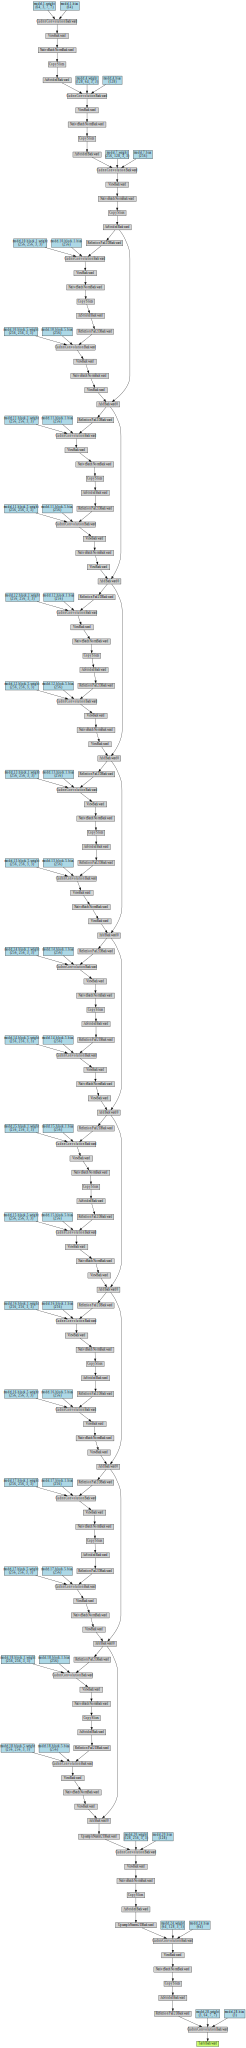

In [0]:
make_dot(G_AB(sample_test_images[:1]), params=dict(G_AB.named_parameters()))

In [0]:
optimizer_G = t.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)
optimizer_D_A = t.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = t.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

In [0]:
loss_GAN = t.nn.MSELoss().to(device)
loss_cycle = t.nn.L1Loss().to(device)
loss_identity = t.nn.L1Loss().to(device)

In [0]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

In [0]:
def sample_images(batches_done):
    
    """Saves a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = G_AB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = G_BA(real_B)
    
    # Arange images along x-axis
    real_A = vutils.make_grid(real_A, nrow=5, normalize=True)
    real_B = vutils.make_grid(real_B, nrow=5, normalize=True)
    fake_A = vutils.make_grid(fake_A, nrow=5, normalize=True)
    fake_B = vutils.make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, "images.png", normalize=False)


In [0]:
def gan_book_keeping(current_epoch,loss_D,loss_G,loss_GAN,loss_cycle,loss_identity,prev_time):
    
    batches_done = current_epoch * len(dataloader) + i
    batches_left = n_epochs * len(dataloader) - batches_done
    
    time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
    prev_time = time.time()

    # Print log
    sys.stdout.write(
        "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
        % (
            current_epoch,
            n_epochs,
            i,
            len(dataloader),
            loss_D.item(),
            loss_G.item(),
            loss_GAN.item(),
            loss_cycle.item(),
            loss_identity.item(),
            time_left,
        )
    )

    # If at sample interval save image
    if batches_done % sample_interval == 0:
        sample_images(batches_done)

In [0]:
Tensor = t.cuda.FloatTensor if str(device)=="cuda" else t.Tensor

for epoch in range(epoch, n_epochs):
    
    for i, batch in enumerate(dataloader):
        prev_time = time.time()

        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))
            
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        # Train Generators
        
        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()
        
        # Identity loss
        loss_id_A = loss_identity(G_BA(real_A), real_A)
        loss_id_B = loss_identity(G_AB(real_B), real_B)
        total_loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = loss_GAN(D_B(fake_B), valid)

        fake_A = G_BA(real_B)
        loss_GAN_BA = loss_GAN(D_A(fake_A), valid)
        
        total_loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = loss_cycle(recov_A, real_A)
        
        recov_B = G_AB(fake_A)
        loss_cycle_B = loss_cycle(recov_B, real_B)

        total_loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

       
        # Total loss
        loss_G = total_loss_GAN + lambda_cyc * total_loss_cycle + lambda_id * total_loss_identity
        
        loss_G.backward()
        optimizer_G.step()


        #  Train Discriminator A
        
        optimizer_D_A.zero_grad()

        loss_real = loss_GAN(D_A(real_A), valid)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = loss_GAN(D_A(fake_A_.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward(
        )
        optimizer_D_A.step()
        
        #  Train Discriminator B

        optimizer_D_B.zero_grad()

        loss_real = loss_GAN(D_B(real_B), valid)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = loss_GAN(D_B(fake_B_.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = (loss_D_A + loss_D_B) / 2
        
        gan_book_keeping(epoch,loss_D,loss_G,total_loss_GAN,total_loss_cycle,total_loss_identity,prev_time)
    

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        t.save(G_AB.state_dict(), "selfie2anime_AB/models/G_AB_%d.pth" % (epoch))
        t.save(G_BA.state_dict(), "selfie2anime_AB/models/G_BA_%d.pth" % (epoch))
        t.save(D_A.state_dict(), "selfie2anime_AB/models/D_A_%d.pth" % (epoch))
        t.save(D_B.state_dict(), "selfie2anime_AB/models/D_B_%d.pth" % (epoch))


[Epoch 0/200] [Batch 8/3400] [D loss: 1.139596] [G loss: 7.121038, adv: 1.046940, cycle: 0.414315, identity: 0.386190] ETA: 2 days, 21:40:58.006794

KeyboardInterrupt: ignored

**Testing**


In [0]:
G_AB_test = GeneratorResNet(input_shape, n_residual_blocks)
G_AB_test.load_state_dict(torch.load("selfie2anime_AB/models/G_AB_100.pth"))

G_AB_test = G_AB_test.to(device)
G_AB_test

In [0]:
Tensor = t.cuda.FloatTensor if str(device)=="cuda" else t.Tensor


sample_A= t.Tensor()

for i in range(1):
    data = iter(val_dataloader).next()
    A = data["A"]
    sample_A = t.cat((sample_A,A),dim=0)

sample_A = sample_A.to(device)

real_A_show = vutils.make_grid(sample_A, nrow=7, normalize=True)
image_grid = real_A_show
real_A_show = real_A_show.detach().cpu().numpy()
real_A_show = real_A_show.transpose([1,2,0])
plt.imshow(real_A_show)

In [0]:
for i in [50,100]:
    with torch.no_grad():
        del G_AB_test
        G_AB_test = GeneratorResNet(input_shape, n_residual_blocks)
        G_AB_test.load_state_dict(torch.load("selfie2anime_AB/models/G_AB_"+str(i)+".pth"))
        G_AB_test = G_AB_test.to(device)

        sample_A.to(device)

        fake_B = G_AB_test(sample_A)
        fake_B_show = vutils.make_grid(fake_B, nrow=7, normalize=True)
        image_grid = t.cat((image_grid, fake_B_show), 1)

save_image(image_grid, "images.jpg", normalize=False)

image_grid = image_grid.detach().cpu().numpy()

image_grid = image_grid.transpose([1,2,0])
plt.imshow(image_grid)

Single Image testing

In [0]:
transforms_ = [
    transforms.Resize(int(img_height), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

]

transform_test = transforms.Compose(transforms_)

In [0]:
image_A = Image.open("/home/anton/Desktop/female_22233.jpg")
item_A = transform_test(image_A)
item_A = item_A.numpy()
item_A = np.expand_dims(item_A,axis=0)
item_A =torch.Tensor(item_A)
item_A = item_A.to(device)

item_A.shape

In [0]:
fake_B = G_AB_test(item_A)
fake_B_show = fake_B.detach().cpu().numpy()
fake_B_show = fake_B_show.squeeze()
fake_B_show = fake_B_show.transpose([1,2,0])
plt.imshow(fake_B_show)